# Arabesque Tiling

This notebook adds arabesque tiling patterned over parts of an image (randomly drawn from a source photos) to: 1) a specified upper fraction of the image, 2) best guess at background which is sky

See the below examples of processed images.

In [1]:
%matplotlib inline
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from skimage.util import img_as_float, img_as_ubyte
import numpy as np
from skimage.transform import rescale
import os
from skimage.morphology import binary_closing, label
from skimage.color import rgb2gray
from math import floor
import random
from scipy.ndimage import gaussian_filter

In [2]:
testfile = 'sunset.jpg'
# Select a random tile from the pool
path = 'tiles'
tilefiles = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.jpg' in file:
            tilefiles.append(os.path.join(r, file))
random.shuffle(tilefiles)
tilefiles[0] = 'tiles/modern.jpg'
testtileimage = mpimg.imread(tilefiles[0])

testimage = mpimg.imread(testfile)
scalefactor = 1024 / max(testimage.shape[0],testimage.shape[1])
testimage = rescale(testimage, scalefactor, anti_aliasing=True, multichannel=True)

In [3]:
def clusterimage(image,numbercenters):
    image = img_as_float(image)
    pic_n = image.reshape(image.shape[0]*image.shape[1], image.shape[2])
    kmeans = KMeans(n_clusters=numbercenters, random_state=0,max_iter=3,n_init=1).fit(pic_n)
#    pic2show = kmeans.cluster_centers_[kmeans.labels_]    
#    cluster_pic = pic2show.reshape(image.shape[0], image.shape[1], image.shape[2])
    return kmeans

testkmeans = clusterimage(testimage,7)

In [4]:
def preptile(image,tileimage):
    scalefactor = 0.2+0.25*np.random.random() # 0.65 # scale this tile
    print(scalefactor)
    upperthreshold = 0.5 # may vary per tile
    randomcolormapslider = 0.2 # amount to use random colors vs. colors found in the image
    numbercenters = 24 # number of colors to paint the tile
    
    # Convert the tile to grayscale and resize
    tileimage = rgb2gray(tileimage)
    tileimage = rescale(tileimage, scalefactor, anti_aliasing=True, multichannel=False)

    # Prep the tile for masking by converting into binary format
    binimg = np.zeros([tileimage.shape[0], tileimage.shape[1]],dtype = 'uint8')
    for i in range(tileimage.shape[0]):
        for j in range(tileimage.shape[1]): 
            if tileimage[i,j] > upperthreshold:
                binimg[i,j] = 255
            else:
                binimg[i,j] = 0                
    # For debug-> plt.imshow(binimg,cmap='binary') 
    
    # Paint the panes in the tiles by closing and labeling blobs
    closing = binary_closing(binimg) 
    labelimg = label(closing)
    # For debug-> plt.imshow(labelimg)
    
    # Now introduce the colortiles
    colorkmeans = clusterimage(image,numbercenters)
    colormap = np.floor(255*colorkmeans.cluster_centers_)
    colormaprand = np.random.randint(0,256, [np.amax(labelimg.shape),3],dtype = 'uint8')

    colortileimg = np.zeros([labelimg.shape[0], labelimg.shape[1],3],dtype = 'uint8')
    for x in range(0,labelimg.shape[0]):
        for y in range(0,labelimg.shape[1]):
            colortileimg[x,y,:] = (1.0-randomcolormapslider)*colormap[(labelimg[x,y]-1)%numbercenters,:] \
                + randomcolormapslider*colormaprand[(labelimg[x,y]-1)%numbercenters,:]               
   
    colortileimg = img_as_float(colortileimg)
    #plt.imshow(colortileimg)
    return colortileimg

colortesttile = preptile(testimage,testtileimage)

0.3434924169681446


0.33878826517110877


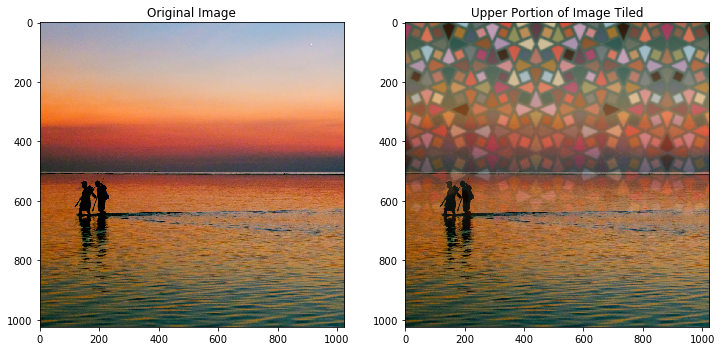

In [5]:
def drawtiles(image,colortileimage):
    horizonline = round(0.75*image.shape[0])
    withGaussian = True
    alphaconstant = 1.0

    xtiles = floor(image.shape[0]/colortileimage.shape[0])+1
    ytiles = floor(image.shape[1]/colortileimage.shape[1])+1
    maskimg = np.zeros([colortileimage.shape[0]*xtiles,colortileimage.shape[1]*ytiles,3],dtype = 'float')
    
     # Tile the image first to be larger than the original image
    xctr = 1
    yctr = 1 
    for x in range(0,image.shape[0],colortileimage.shape[0]):
        xctr = xctr + 1
        yctr = 0
        for y in range(0,image.shape[1],colortileimage.shape[1]):
            yctr = yctr + 1
            thistile = colortileimage
            if xctr%2:            
                thistile = np.flipud(thistile)
            if yctr%2:
                thistile = np.fliplr(thistile)
            
            maskimg[x:x+colortileimage.shape[0],y:y+colortileimage.shape[1],:] = thistile         
            
    maskimg = maskimg[0:image.shape[0],0:image.shape[1],:]
    if withGaussian:
        maskimg[:,:,0] = gaussian_filter(maskimg[:,:,0],2.5)
        maskimg[:,:,1] = gaussian_filter(maskimg[:,:,1],2.5)
        maskimg[:,:,2] = gaussian_filter(maskimg[:,:,2],2.5)
    
    #outimg=alpha*maskimg+(1-alpha)*image
    alpha = alphaconstant*np.ones([image.shape[0],image.shape[1],3])
    for x in range(0,horizonline):
        alpha[x,:] = alpha[x,:] * ((horizonline-x)/horizonline)
    outimg = np.multiply(alpha,maskimg) + np.multiply(1-alpha,image)    
    outimg[horizonline:,:,:] = image[horizonline:,:,:]
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12,12)
    ax1.set_title('Original Image')
    ax1.imshow(image)
    ax2.set_title('Upper Portion of Image Tiled')
    ax2.imshow(outimg)

    return outimg

dtilesimg = drawtiles(testimage,preptile(testimage,testtileimage))

tiles/modern.jpg
0.37360045946397613


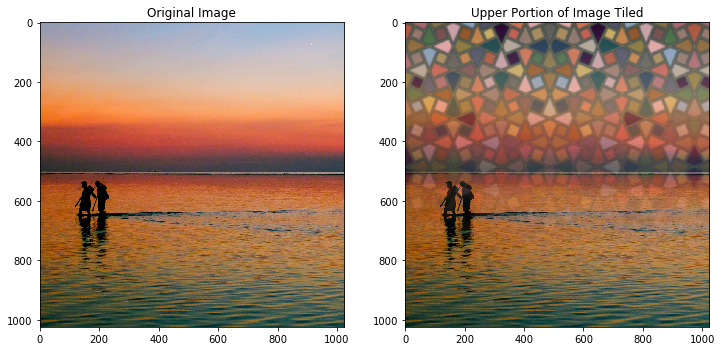

In [6]:
def arabiantiling(image):
    
    # Select a random tile from the pool
    path = 'tiles'
    tilefiles = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if '.jpg' in file:
                tilefiles.append(os.path.join(r, file))
    random.shuffle(tilefiles)
    tileimage = mpimg.imread(tilefiles[0])
    print(tilefiles[0])
    colortilepatternimage = preptile(image,tileimage)
    
    outimages = []
    outimages.append(drawtiles(image,colortilepatternimage))
    return outimages

outimglist = arabiantiling(testimage)

tiles/vector.jpg
0.42941240943362774
tiles/newpattern.jpg
0.25660528659026505
tiles/bands.jpg
0.35716194083773156
tiles/newpattern.jpg
0.2527942448590149
tiles/modern.jpg
0.279322153676532


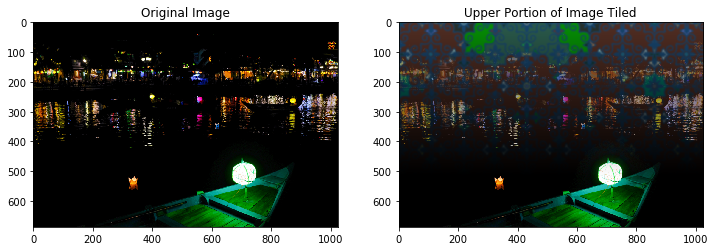

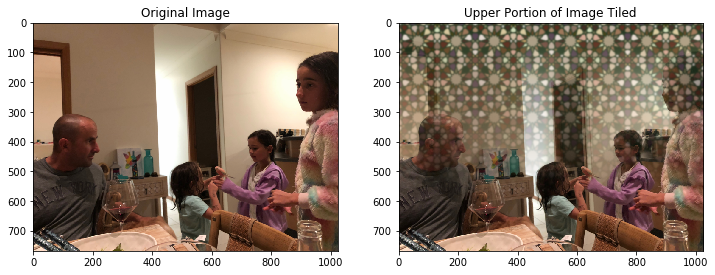

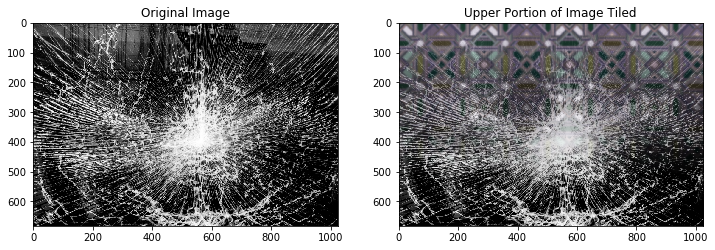

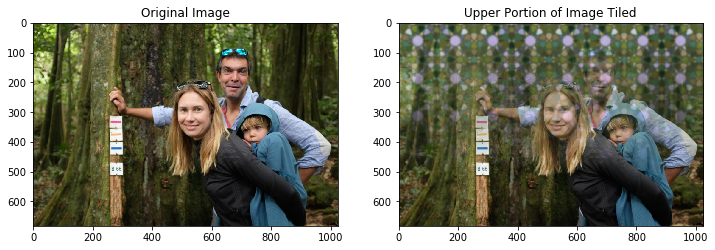

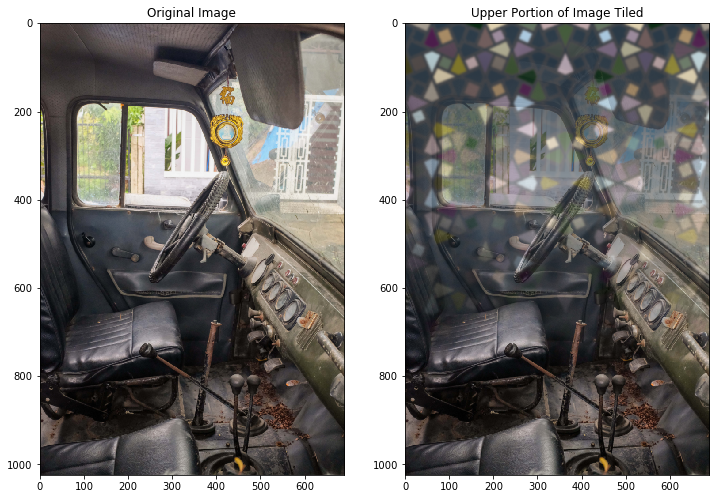

In [7]:
# load input files and set parameters
# this runs across a few random files in subdirectories specified under path
numberoffiles = 5

# Add parent directory with test photos here
path = '/Users/jimkleban/Desktop/Photos'
outpath = '/Users/jimkleban/Desktop/Autogenerated/'
files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.jpg' in file:
            files.append(os.path.join(r, file))

random.shuffle(files)

for r in range(0,numberoffiles):
    img = mpimg.imread(files[r])
    scalefactor = 1024 / max(img.shape[0],img.shape[1])
    img = rescale(img, scalefactor, anti_aliasing=True, multichannel=True)
    outputimglist = arabiantiling(img)
    
    filebase = files[r].split('/')[-1]
    basename = filebase.split('.')[0]
    ext = filebase.split('.')[1]
    
    plt.imsave(outpath+basename+'_1024.'+ext,img)
    ctr = 1
    for outputimg in outputimglist:
        plt.imsave(outpath+basename+'_1024_tiled'+str(ctr)+'.'+ext, outputimg)
        ctr = ctr + 1
        